In [300]:
import numpy as np
import os
import json
import pandas as pd
import csv
from datetime import date
import matplotlib.pylab as plt
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

# preprocess
#  * pure text 2021-
#     * clean up text: stopwords, stemming, lowercase, strip urls/bad characters/HTML/etc, word-tokenization (incl. contractions), drop numbers
#     * text to vectors: BOW, also TFIDF, also word embeddings
#  * tabular 2008-21-
#     * EDA - plot distributions of interesting stuff
#     * discard / impute empty data
#     * normalize

# tasks
# * train model on numbers (e.g. profits for some years of some companies, predict future year)
# * cluster/PCA text vectors to see if industries emerge. (may need to join on external labels after the fact to measure accuracy)
# * see if model trained on text can predict financials (e.g. profit higher than cluster avg)

# for today
# * preprocess and join on 2021

# conda list -e > requirements.txt

[nltk_data] Downloading package wordnet to /Users/keyur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/keyur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [301]:
# Create list of json filenames (one per company) for Edgar reports
path_to_json = 'sec_edgar_annual_financial_filings_2021/extracted/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# load json dicts into dataframe (rows are companies, columns are fields)
list_of_data = []

for file_name in json_files:
  with open(f'./{path_to_json}{file_name}', 'r') as f:
    data = json.load(f)
    list_of_data.append(data)

df_text = pd.DataFrame(list_of_data)
df_text["cik"] = df_text["cik"].astype(int)

# Keep only rows concerning period of 2020
REPORT_PERIOD = '2020'
df_text = df_text[df_text["period_of_report"].apply(lambda date_str: date_str[:4] == REPORT_PERIOD)].reset_index()

print(df_text.shape)
df_text.head()

(116, 34)


,index,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,...,item_8,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15
0,1,1401680,Cornerstone OnDemand Inc,10-K,2021-02-22,2020-12-31,7372,DE,CA,1231,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\n(a) Evaluati...,"Item 9B. Other Information\nOn February 17, 20...","Item 10. Directors, Executive Officers, and Co...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,2,843006,ISSUER DIRECT CORP,10-K,2021-03-04,2020-12-31,2750,None,NC,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES.\nManagement’...,ITEM 9B. OTHER INFORMATION.\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION.\nThe informat...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,ITEM 15. EXHIBITS.\n(a) Financial Statements\n...
2,4,1567771,BRIDGEWAY NATIONAL CORP.,10-K,2021-06-01,2020-12-31,2860,DE,DC,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nSummary Compe...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."
3,6,1212458,PROOFPOINT INC,10-K,2021-02-19,2020-12-31,7374,DE,CA,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."
4,9,1131554,SYNCHRONOSS TECHNOLOGIES INC,10-K,2021-03-16,2020-12-31,7371,None,NJ,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nDisclosure C...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nInformation c...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,ITEM 15. EXHIBITS\n(a)(1) Financial Statements...


In [302]:
# Preprocessing the df_text
text_columns = ['item_1', 'item_1A', 'item_1B', 'item_2', 'item_3',
                'item_4', 'item_5', 'item_6', 'item_7', 'item_7A', 'item_8', 'item_9',
                'item_9A', 'item_9B', 'item_10', 'item_11', 'item_12', 'item_13',
                'item_14', 'item_15']

def lemmatize_text(text):
  w_tokenizer = WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

for col in text_columns:
  # Make everything lowercase
  df_text[col] = df_text[col].str.lower()
  # Replace all the special characters with spaces
  # HTML Tags, random escape characters (newline, tab)
  df_text[col] = df_text[col].str.replace(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\n', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\t', ' ', regex=True)
  # https://stackoverflow.com/a/23996414 
  # Keep non-special characters blanket regex
  df_text[col] = df_text[col].str.replace(r'[^a-zA-Z0-9 \n\.]', ' ', regex=True)
  # Replace contractions
  df_text[col] = df_text[col].apply(lambda x: contractions.fix(x))
  # Strip punctuation
  df_text[col] = df_text[col].str.replace(r'[^\w\s]',' ', regex=True)

  # Now remove stop words
  stop = stopwords.words('english')
  pat = r'\b(?:{})\b'.format('|'.join(stop))
  df_text[col] = df_text[col].str.replace(pat, ' ', regex=True)
  # Handles any empty space between words / due to replacements
  df_text[col] = df_text[col].str.replace(r'\s+', ' ', regex=True)

  # Remove numbers
  df_text[col] = df_text[col].str.replace('\d+', ' ', regex=True)

  # Lemmatize text 
  df_text[col] = df_text[col].apply(lemmatize_text)

# Example tokenized text field
df_text['item_1'][0]

# Non tokenized version
df_text_non_tokenized = df_text.copy()
for col in text_columns:
  df_text_non_tokenized[col] = df_text_non_tokenized[col].str.join(" ")


In [341]:
# Create list of json filenames (one per company) for SEC data made usable tables
path_to_csv = 'sec_company_facts_all_10Q_and_10K_financial_data/sec_data_made_useable/sec_data_made_useable/'
csv_files = [pos_json for pos_json in os.listdir(path_to_csv) if pos_json.endswith('.csv')]

list_of_data = []

NUM_FILES = -1  # only parse first N files

for file_name in csv_files[:NUM_FILES]:
  with open(f'./{path_to_csv}{file_name}', 'r') as f:
    data = list(csv.DictReader(f, delimiter=','))

    # each row is one filing year for the same company
    for year_data in data:
      # print(type(int(year_data["CIK"][3:])))
      # print(type(df_text["cik"][0]))

      if (
        year_data["end"][:4] == REPORT_PERIOD and
        year_data["form"] == "10-K" and
        year_data["Currency"] == "USD" and
        int(year_data["CIK"][3:]) in df_text["cik"].values
      ):
        list_of_data.append(year_data)

df_table_raw = pd.DataFrame(list_of_data).replace('', np.nan)
df_table = df_table_raw.drop(['end', 'filed', 'form', 'Ticker', 'Currency', 'Name'], axis=1)
df_table["CIK"] = df_table["CIK"].apply(lambda cik: int(cik[3:]))

print(df_table.shape)
df_table.head()

(104, 3341)


,CIK,AccountsPayableAndAccruedLiabilitiesCurrent,AccountsPayableCurrent,AccountsReceivableGross,AccountsReceivableNet,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccruedProfessionalFeesCurrent,AccruedProfessionalFeesCurrentAndNoncurrent,AccruedRoyaltiesCurrent,...,ProductWarrantyExpense,ReplacementReserveEscrow,SaleLeasebackTransactionNetProceeds,StandardAndExtendedProductWarrantyAccrualForeignCurrencyTranslationGainLoss,StandardProductWarrantyAccrualCurrencyTranslationIncreaseDecrease,StandardProductWarrantyAccrualCurrent,StandardProductWarrantyAccrualForeignCurrencyTranslationGainLoss,StandardProductWarrantyAccrualNoncurrent,StandardProductWarrantyAccrualPeriodIncreaseDecrease,VariableInterestEntityNonconsolidatedCarryingAmountAssetsAndLiabilitiesNet
0,1467761,NaN,11744834.0,9376937.0,9203334.0,9203334.0,7465063.0,853402.0,618308.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1794515,NaN,8600000.0,NaN,NaN,121200000.0,81500000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1280058,NaN,NaN,NaN,NaN,95404000.0,NaN,NaN,4808000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,736012,NaN,408000.0,NaN,1233000.0,1233000.0,628000.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,829323,NaN,4048260.0,NaN,NaN,6227610.0,4216448.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

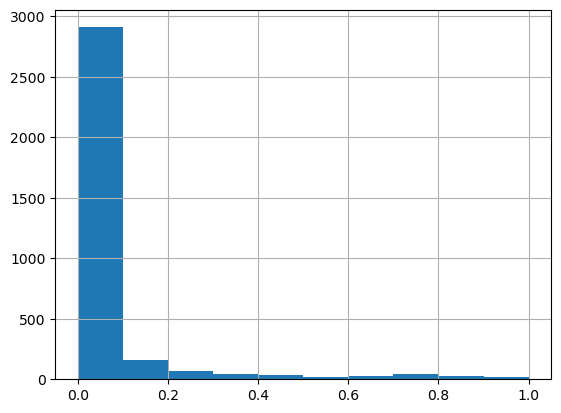

In [342]:
# We can see that there are a huge number of fields, but almost all of them are missing
# (because they are for 10-Qs or other forms)
(df_table.count(axis=0) / df_table.shape[0]).hist()

14
Index(['CIK', 'Assets', 'AssetsCurrent',
       'CashAndCashEquivalentsAtCarryingValue',
       'DeferredTaxAssetsValuationAllowance',
       'LiabilitiesAndStockholdersEquity', 'LiabilitiesCurrent',
       'NetCashProvidedByUsedInFinancingActivities',
       'NetCashProvidedByUsedInInvestingActivities',
       'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss',
       'OperatingIncomeLoss', 'RetainedEarningsAccumulatedDeficit',
       'StockholdersEquity'],
      dtype='object')


<AxesSubplot: >

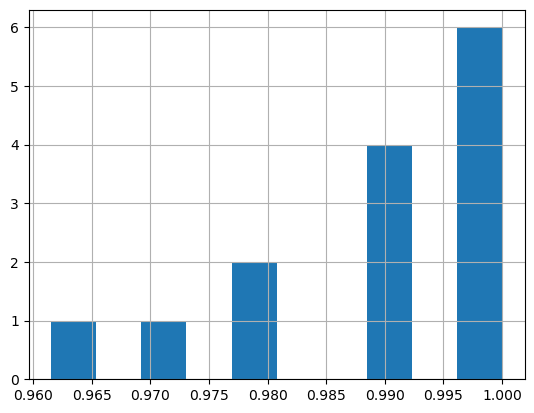

In [343]:
# What if we only took the fields that were filled out for a high percent of the companies?
FILLED_PCT_MIN = 0.95
field_filled_pct = df_table.count(axis=0) / df_table.shape[0]
df_table = df_table.loc[:, field_filled_pct >= FILLED_PCT_MIN]
print(len(df_table.columns))

# After manual inspection of these, we were reasonably happy that they captured many of the "most important" values
print(df_table.columns)

(df_table.count(axis=0) / df_table.shape[0]).hist()

# np.log(df_table["LiabilitiesAndStockholdersEquity"].astype(float)).hist()

/var/folders/x_/wybm3nyn2hvdps5b2tssqs9h0000gn/T/ipykernel_96503/57063981.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_table.iloc[:, 1:] = simp.fit_transform(df_table.iloc[:, 1:])


array([[<AxesSubplot: title={'center': 'Assets'}>,
        <AxesSubplot: title={'center': 'AssetsCurrent'}>,
        <AxesSubplot: title={'center': 'CashAndCashEquivalentsAtCarryingValue'}>,
        <AxesSubplot: title={'center': 'DeferredTaxAssetsValuationAllowance'}>],
       [<AxesSubplot: title={'center': 'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot: title={'center': 'LiabilitiesCurrent'}>,
        <AxesSubplot: title={'center': 'NetCashProvidedByUsedInFinancingActivities'}>,
        <AxesSubplot: title={'center': 'NetCashProvidedByUsedInInvestingActivities'}>],
       [<AxesSubplot: title={'center': 'NetCashProvidedByUsedInOperatingActivities'}>,
        <AxesSubplot: title={'center': 'NetIncomeLoss'}>,
        <AxesSubplot: title={'center': 'OperatingIncomeLoss'}>,
        <AxesSubplot: title={'center': 'RetainedEarningsAccumulatedDeficit'}>],
       [<AxesSubplot: title={'center': 'StockholdersEquity'}>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], 

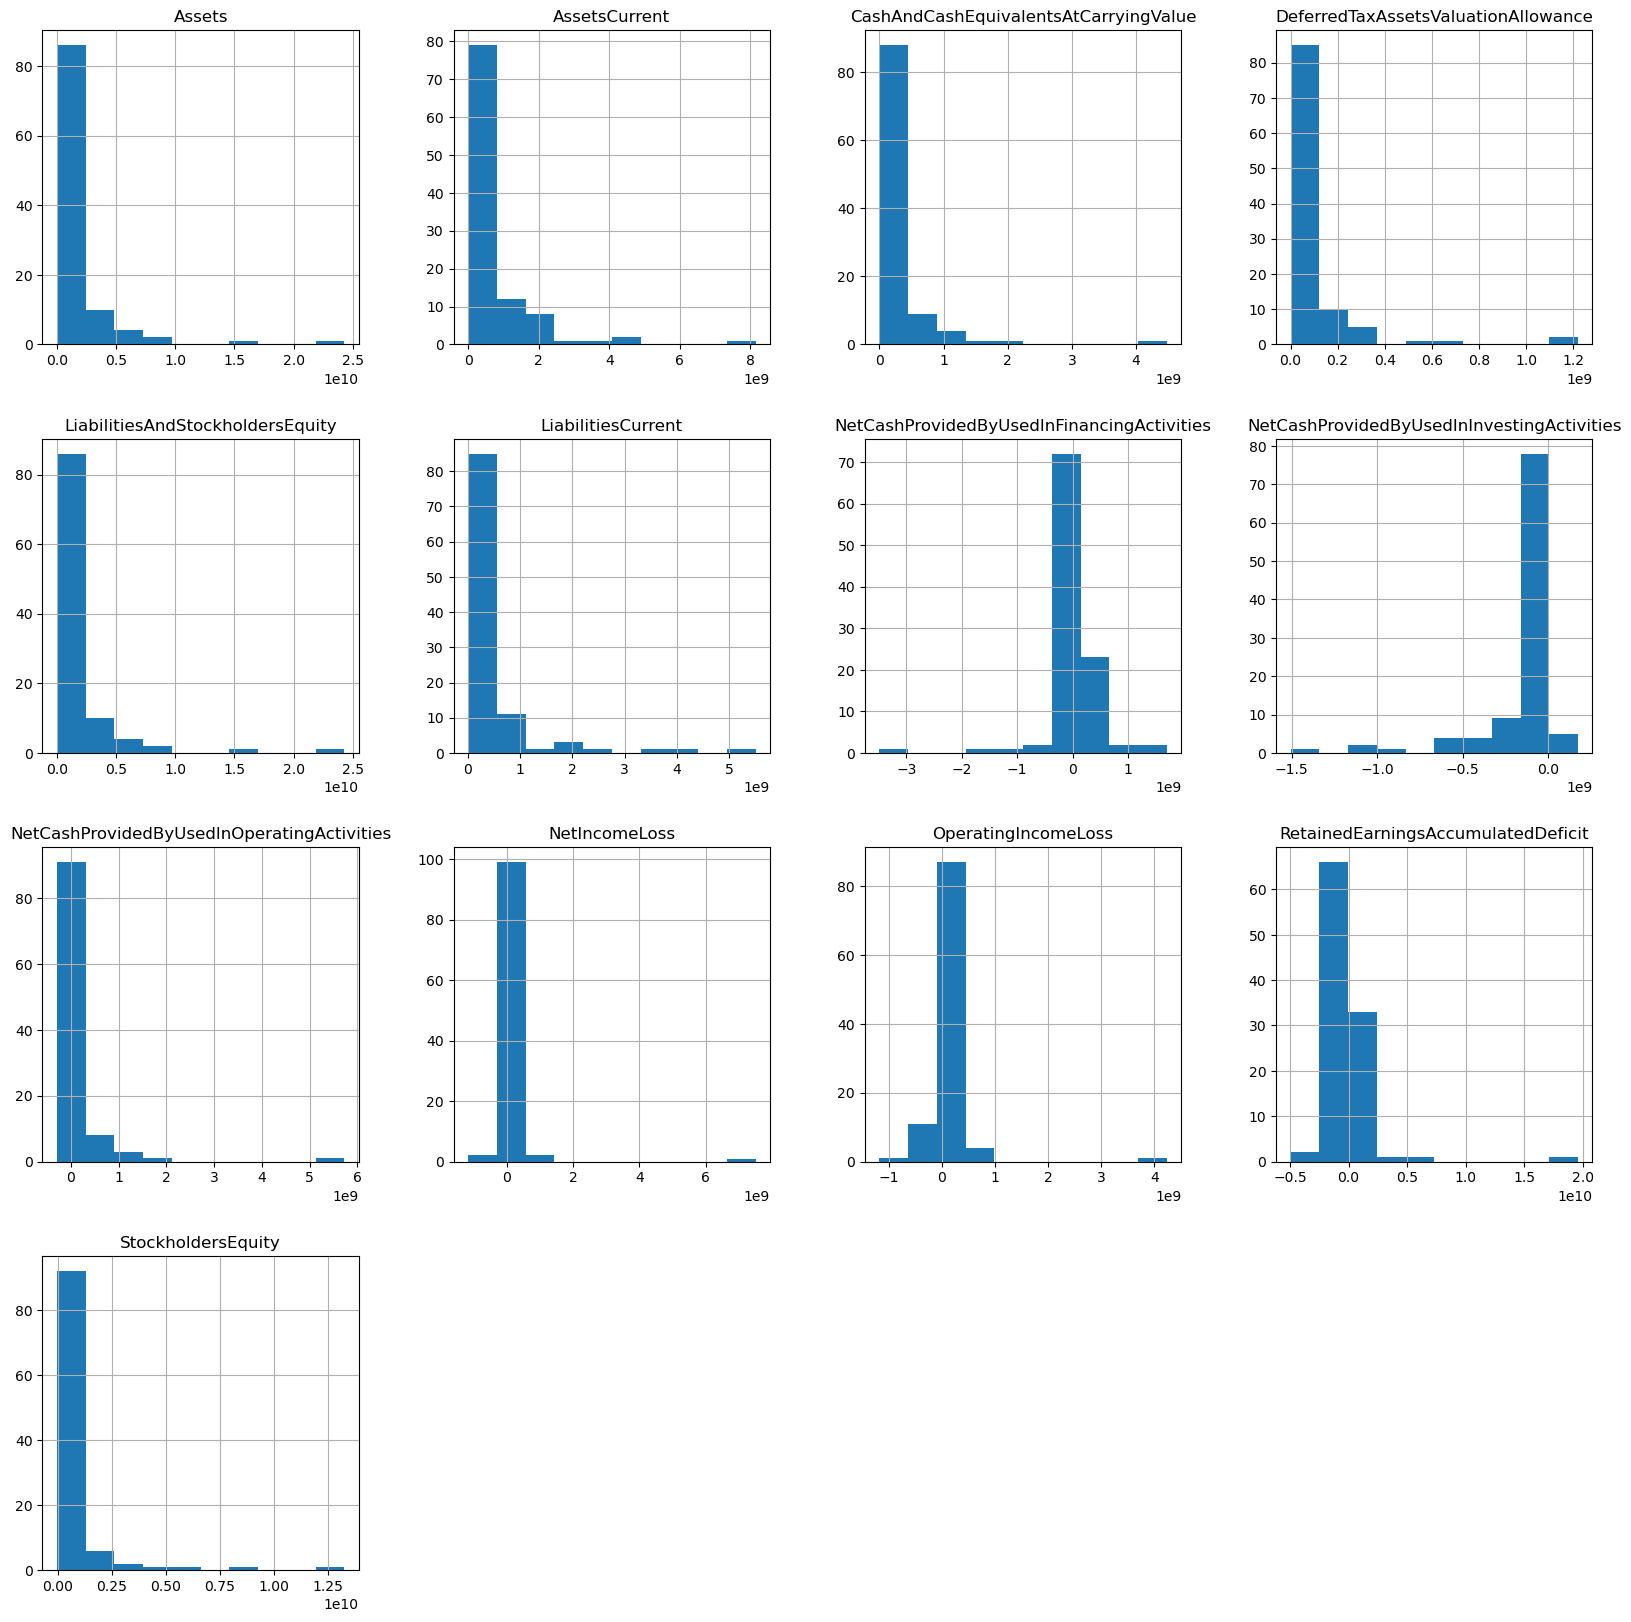

In [344]:
from sklearn.impute import SimpleImputer

# Impute missing values as median
simp = SimpleImputer(strategy='median')
df_table.iloc[:, 1:] = simp.fit_transform(df_table.iloc[:, 1:])

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

array([[<AxesSubplot: title={'center': 'Assets'}>,
        <AxesSubplot: title={'center': 'AssetsCurrent'}>,
        <AxesSubplot: title={'center': 'CashAndCashEquivalentsAtCarryingValue'}>,
        <AxesSubplot: title={'center': 'DeferredTaxAssetsValuationAllowance'}>],
       [<AxesSubplot: title={'center': 'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot: title={'center': 'LiabilitiesCurrent'}>,
        <AxesSubplot: title={'center': 'NetCashProvidedByUsedInFinancingActivities'}>,
        <AxesSubplot: title={'center': 'NetCashProvidedByUsedInInvestingActivities'}>],
       [<AxesSubplot: title={'center': 'NetCashProvidedByUsedInOperatingActivities'}>,
        <AxesSubplot: title={'center': 'NetIncomeLoss'}>,
        <AxesSubplot: title={'center': 'OperatingIncomeLoss'}>,
        <AxesSubplot: title={'center': 'RetainedEarningsAccumulatedDeficit'}>],
       [<AxesSubplot: title={'center': 'StockholdersEquity'}>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], 

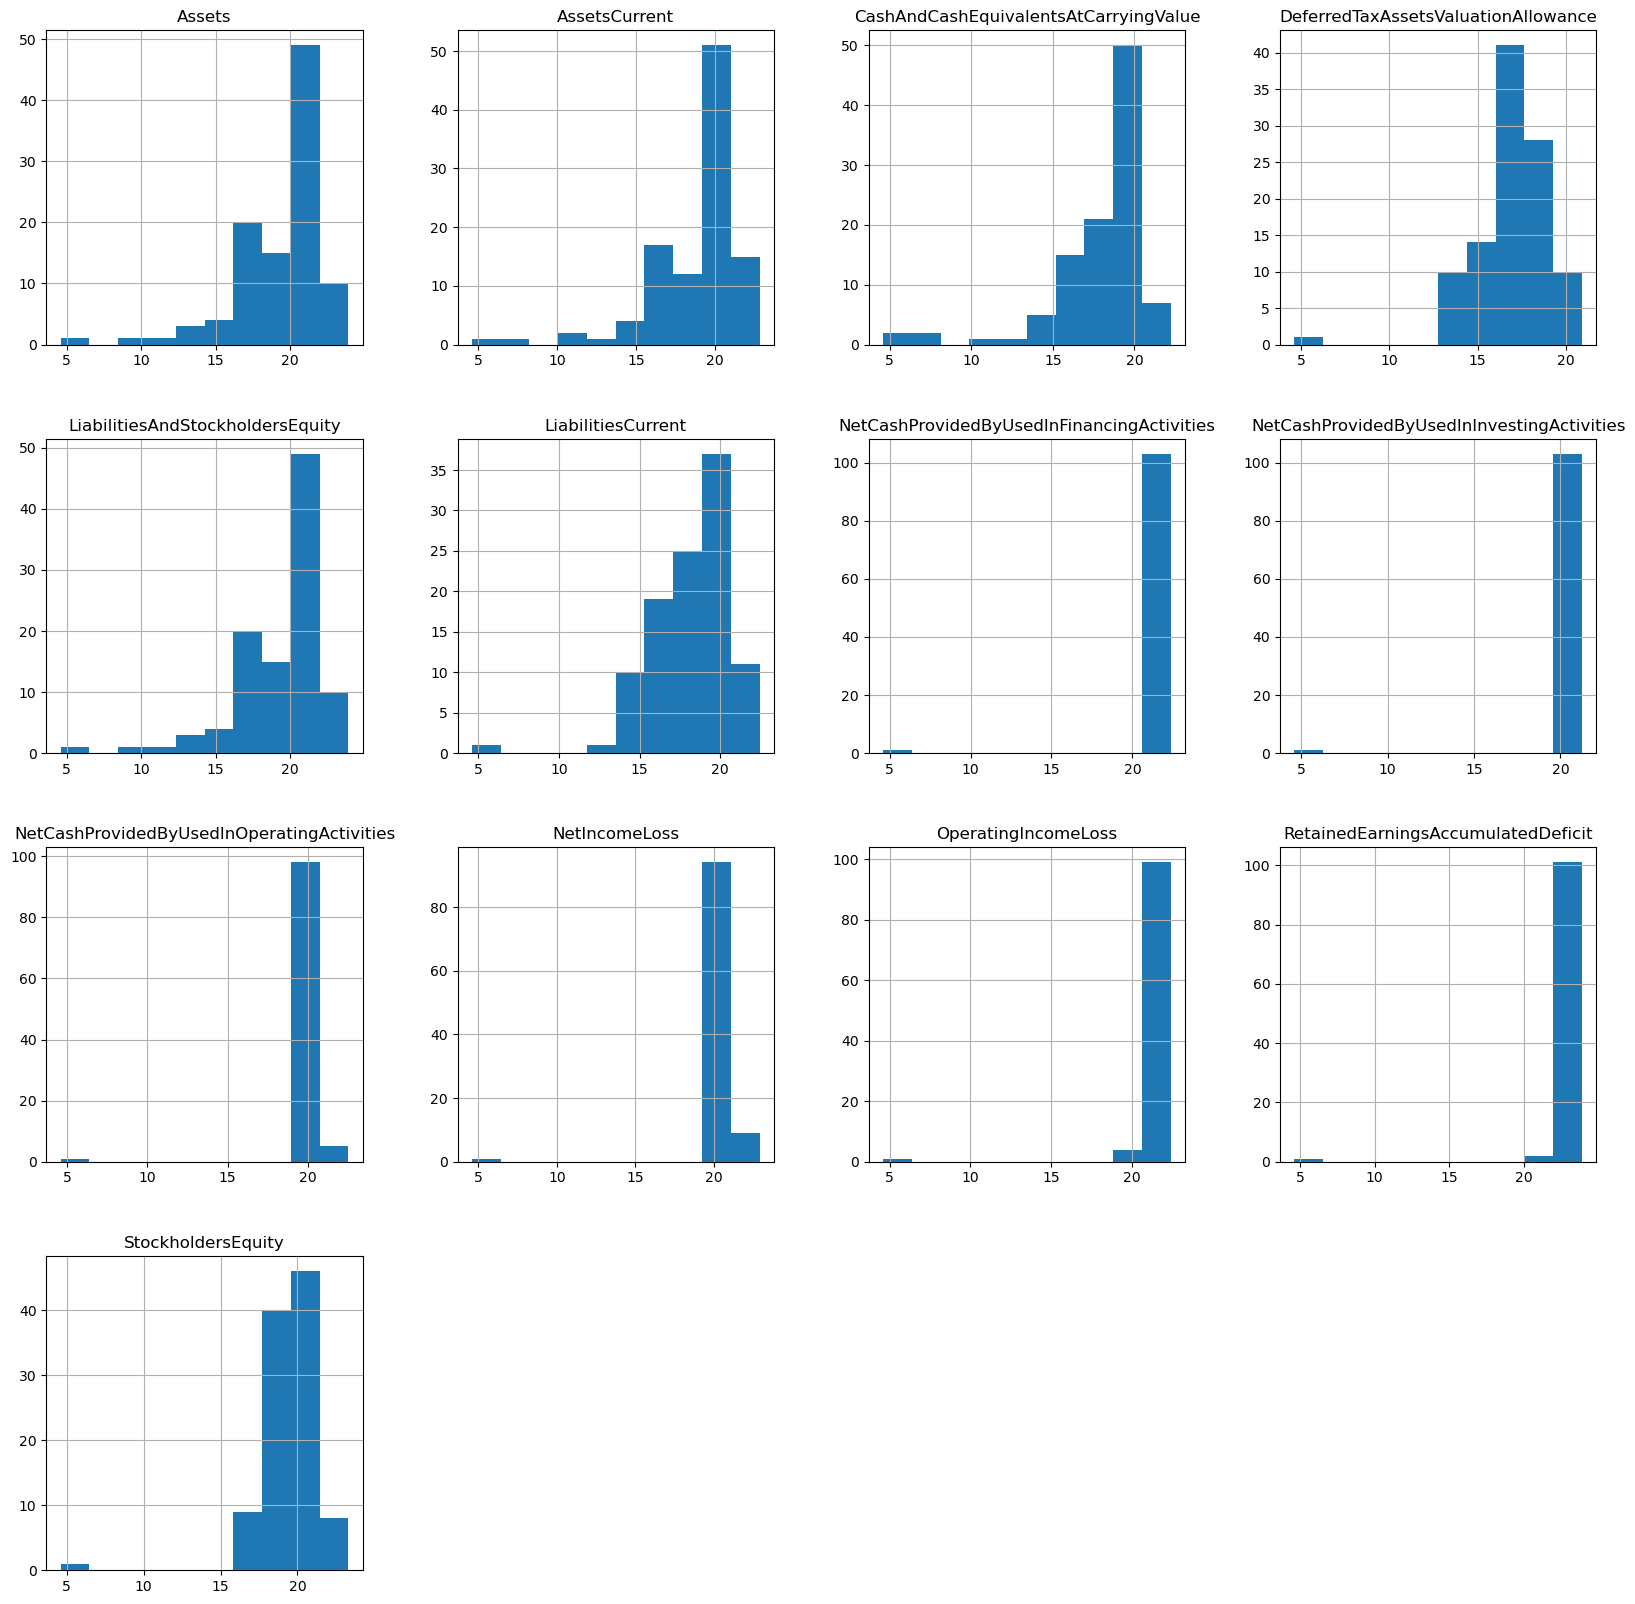

In [345]:
# We want to log normalize all the columns but some are negative or zero so this fails.
# Thus we can subtract the min (so each feature's new min is 0) and then add a tiny constant to make it always positive
df_table.iloc[:, 1:] = np.log(df_table.iloc[:, 1:] - df_table.iloc[:, 1:].min(axis=0) + 100)

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

array([[<AxesSubplot: title={'center': 'Assets'}>,
        <AxesSubplot: title={'center': 'AssetsCurrent'}>,
        <AxesSubplot: title={'center': 'CashAndCashEquivalentsAtCarryingValue'}>,
        <AxesSubplot: title={'center': 'DeferredTaxAssetsValuationAllowance'}>],
       [<AxesSubplot: title={'center': 'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot: title={'center': 'LiabilitiesCurrent'}>,
        <AxesSubplot: title={'center': 'NetCashProvidedByUsedInFinancingActivities'}>,
        <AxesSubplot: title={'center': 'NetCashProvidedByUsedInInvestingActivities'}>],
       [<AxesSubplot: title={'center': 'NetCashProvidedByUsedInOperatingActivities'}>,
        <AxesSubplot: title={'center': 'NetIncomeLoss'}>,
        <AxesSubplot: title={'center': 'OperatingIncomeLoss'}>,
        <AxesSubplot: title={'center': 'RetainedEarningsAccumulatedDeficit'}>],
       [<AxesSubplot: title={'center': 'StockholdersEquity'}>,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], 

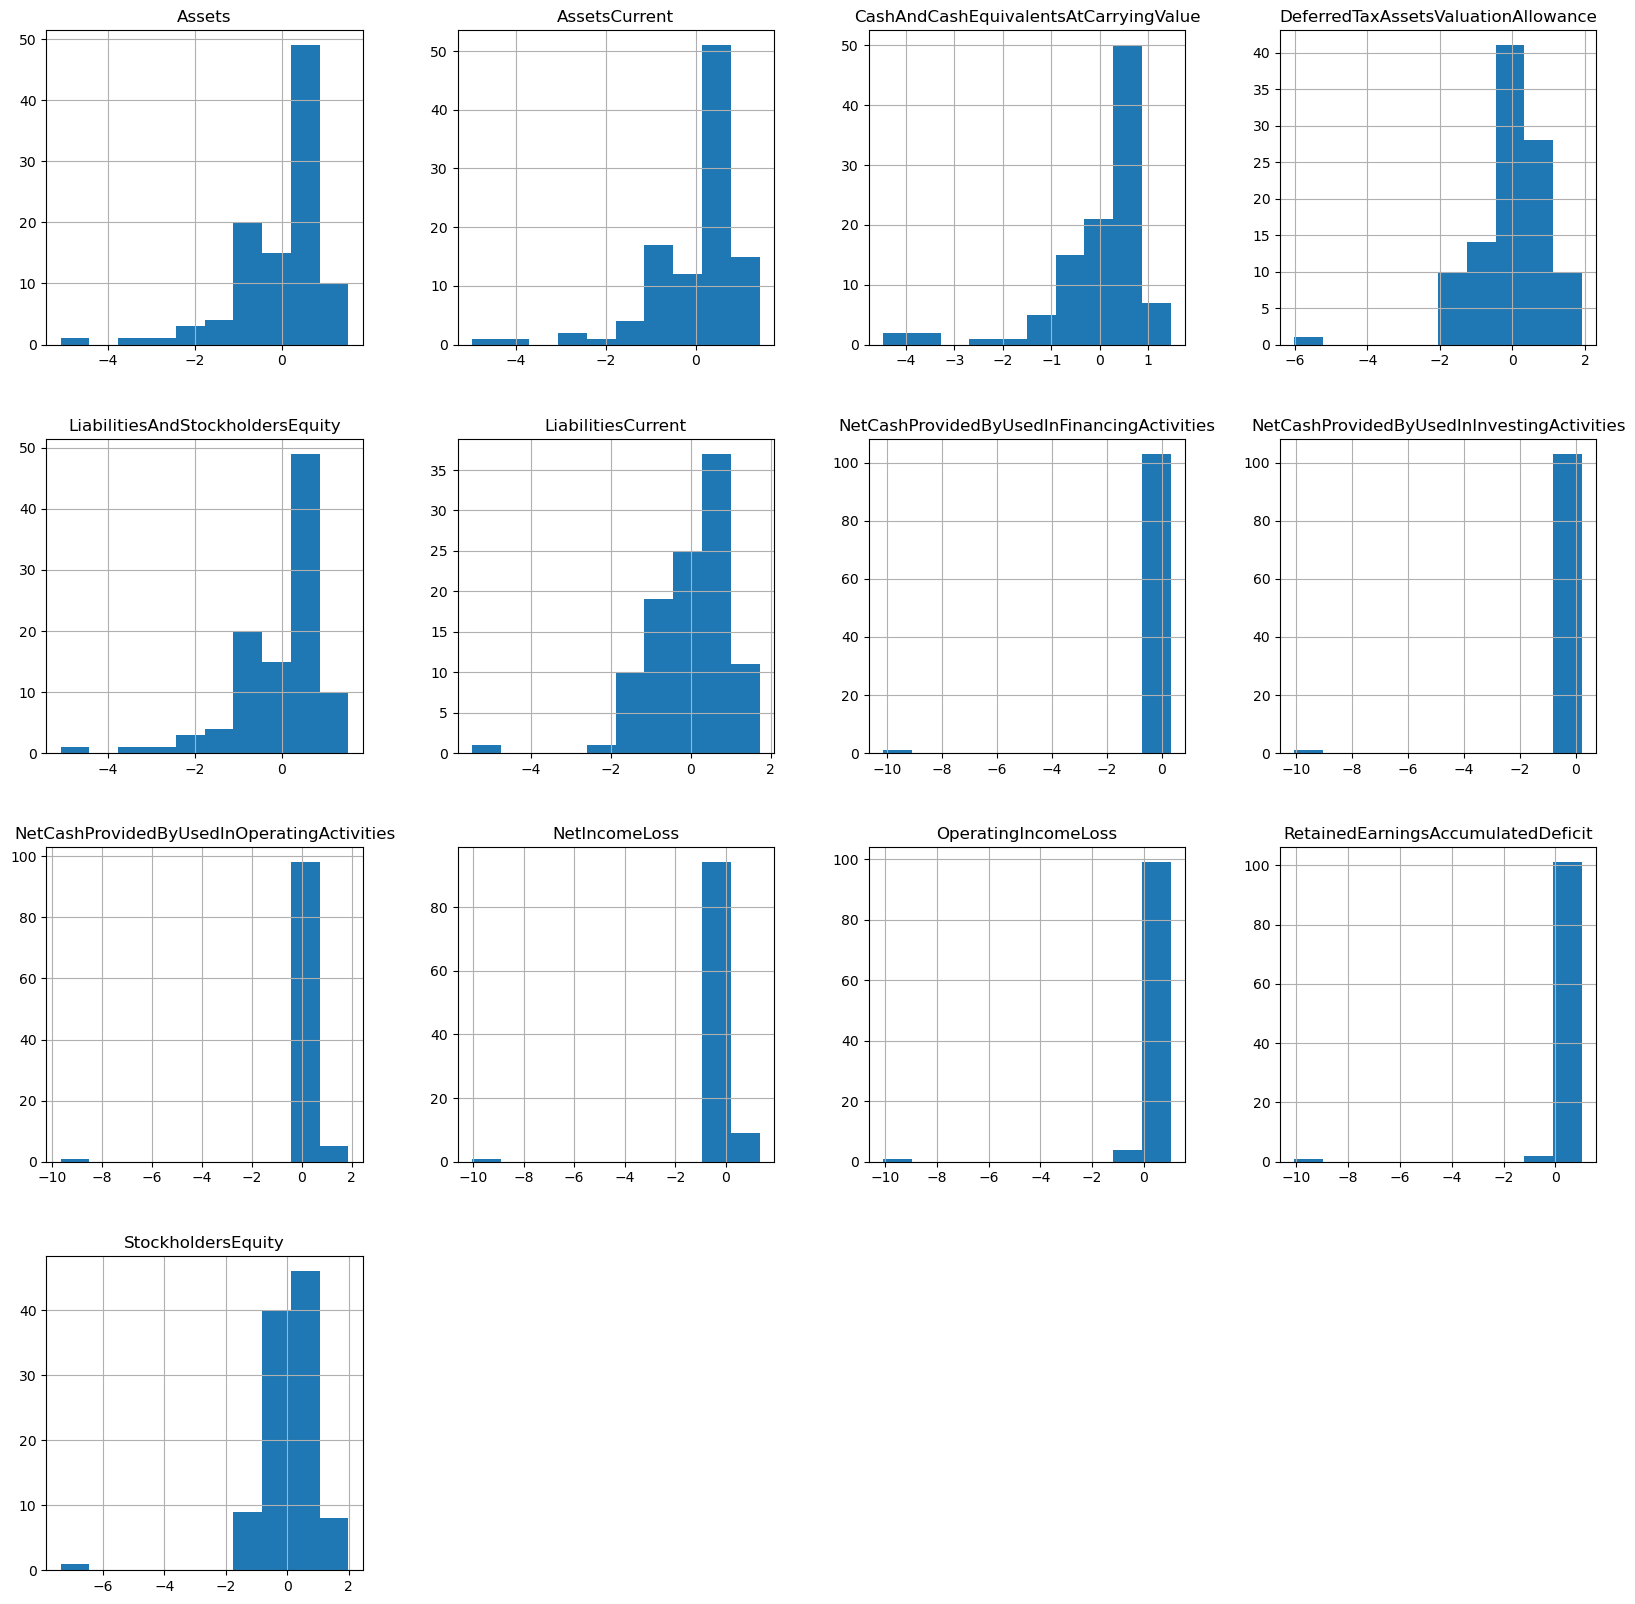

In [346]:
from sklearn.preprocessing import StandardScaler

# Standard scale features to have mean 0 and variance 1
sc = StandardScaler()
df_table.iloc[:, 1:] = sc.fit_transform(df_table.iloc[:, 1:])

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

In [347]:
##########
# Join df_text and df_table on CIK

df_joined = df_text_non_tokenized.join(df_table.set_index("CIK"), on="cik", how="inner").reset_index()
df_joined = df_joined.drop(["index", "level_0"], axis=1)
print(df_joined.shape)

df_joined.head()

(104, 46)


,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,filing_html_index,...,DeferredTaxAssetsValuationAllowance,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInOperatingActivities,NetIncomeLoss,OperatingIncomeLoss,RetainedEarningsAccumulatedDeficit,StockholdersEquity
0,843006,ISSUER DIRECT CORP,10-K,2021-03-04,2020-12-31,2750,None,NC,1231,https://www.sec.gov/Archives/edgar/data/843006...,...,0.112939,-0.710641,-1.149503,0.086056,0.156756,-0.061113,0.085130,0.086218,0.104591,-0.593752
1,1567771,BRIDGEWAY NATIONAL CORP.,10-K,2021-06-01,2020-12-31,2860,DE,DC,1231,https://www.sec.gov/Archives/edgar/data/156777...,...,-1.600419,-2.005280,-1.227807,0.086356,0.156733,-0.072987,0.080176,0.083665,0.102628,-0.861119
2,1050446,MICROSTRATEGY Inc,10-K,2021-02-12,2020-12-31,7372,DE,VA,1231,https://www.sec.gov/Archives/edgar/data/105044...,...,-1.424214,0.572582,0.527013,0.174202,-0.539706,0.036379,0.081407,0.077503,0.166890,0.435947
3,1288847,"Five9, Inc.",10-K,2021-03-01,2020-12-31,7374,DE,CA,1231,https://www.sec.gov/Archives/edgar/data/128884...,...,0.373979,0.462559,0.116858,0.158636,-0.024086,0.061043,0.057109,0.079642,0.080529,0.132238
4,1167419,"Riot Blockchain, Inc.",10-K,2021-03-31,2020-12-31,7374,NV,CO,1231,https://www.sec.gov/Archives/edgar/data/116741...,...,0.409932,0.004511,-1.416911,0.128428,0.143154,-0.095211,0.077208,0.077230,0.076696,0.129035


[13, 7, 4, 8, 9, 25, 6, 12, 15, 5] defaultdict(<class 'list'>, {7: [843006, 1615165, 948708, 1348036, 1810806, 1389002, 1517375, 1046327, 1467623, 829323, 1169652, 1803696, 1102993], 9: [1567771, 1001601, 1567900, 1353499, 1081745, 837852, 1389067], 3: [1050446, 1031308, 1084048, 1410384], 8: [1288847, 1402436, 1013857, 884144, 860731, 1459417, 1671933, 1590955], 5: [1167419, 1362190, 1682325, 1321655, 1624512, 1021435, 1373715, 1084384, 892482], 4: [1433195, 1445305, 1794515, 1739942, 1392972, 1561550, 1447669, 1627857, 1404655, 1463172, 1477333, 1666134, 1660280, 1517413, 1739936, 1560327, 1701732, 1576169, 1437352, 1689923, 1337619, 1459200, 1800667, 1351636, 1015739], 0: [1054721, 814549, 1084577, 1017655, 1342936, 1019034], 2: [1505155, 877890, 1052054, 944480, 876167, 1064722, 935036, 736012, 320340, 1013462, 1467761, 1044777], 1: [1441683, 1107843, 816761, 1679826, 1724570, 1092699, 1056696, 1580808, 1082324, 796343, 1280058, 1806837, 1721947, 1725057, 1262039], 6: [746210, 9416

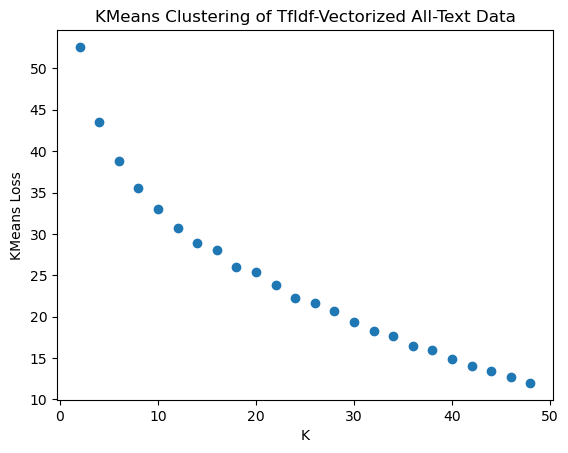

In [376]:
#########
# Preprocess df_text

from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Concatenate all text fields and then vectorize the whole thing
df_joined["all_text"] = df_joined.loc[:, text_columns].sum(axis=1)

# Vectorize this concatenated string
# vec = CountVectorizer(max_df=0.95, binary=True)
vec = TfidfVectorizer(max_df=0.95, max_features=50)
X_text = vec.fit_transform(df_joined["all_text"])

#########
# Cluster X_text
losses = {}

# cluster on text ONLY
for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_text)
    labels_txt = km.predict(X_text)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of TfIdf-Vectorized All-Text Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")


# Inspect the text clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_text)
labels_txt = km.predict(X_text)

cluster_ciks = defaultdict(list)
for row, label in enumerate(labels_txt):
    cluster_ciks[label].append(df_joined["cik"][row])

print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    print("Label", label)
    print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])


Text(0, 0.5, 'KMeans Loss')

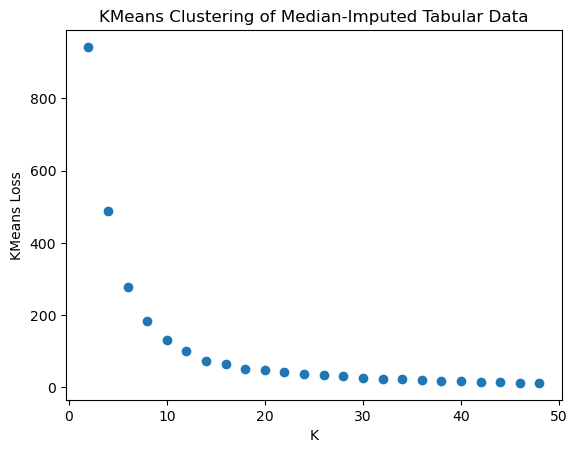

In [356]:
#######
# cluster on tabular/financials ONLY
X_table = df_joined[df_table.columns[1:]]

# use kmeans
losses = {}

for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_table)
    labels_tab = km.predict(X_table)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

In [357]:
# Inspect the tabular clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_table)
labels_tab = km.predict(X_table)

cluster_ciks = defaultdict(list)
for row, label in enumerate(labels_tab):
    cluster_ciks[label].append(df_joined["cik"][row])

print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    print("Label", label)
    print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])

[27, 4, 40, 1, 27, 1, 1, 1, 1, 1] defaultdict(<class 'list'>, {0: [843006, 1054721, 1052054, 1362190, 746210, 944480, 1001601, 736012, 1567900, 948708, 941685, 1084577, 1389002, 320340, 1624512, 1046327, 1467761, 922521, 829323, 1017655, 1081745, 1351636, 1021435, 1084384, 892482, 1015739, 1019034], 3: [1567771, 1064722, 1342936, 1389067], 1: [1050446, 1288847, 1167419, 1031308, 1505155, 1445305, 1392972, 1013857, 1441683, 884144, 876167, 814549, 1682325, 1615165, 1107843, 1627857, 1679826, 1724570, 1092699, 1056696, 1580808, 1082324, 1666134, 1660280, 1517413, 860731, 1517375, 1560327, 1701732, 1806837, 1721947, 1437352, 1337619, 1169652, 1459200, 1800667, 1044777, 1102993, 1626450, 837852], 9: [1433195], 6: [1402436, 1794515, 1739942, 877890, 1561550, 1447669, 935036, 1404655, 816761, 1348036, 1810806, 1463172, 1477333, 1084048, 1739936, 1013462, 1459417, 1280058, 1467623, 1671933, 1689923, 1725057, 1590955, 1803696, 1410384, 1262039, 1370880], 2: [1321655], 4: [796343], 8: [1576169]

In [360]:
# Compare similarity of clusterings on TEXT ONLY and TABULAR ONLY
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

print("Adj Rand score:", adjusted_rand_score(labels_tab, labels_txt))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab, labels_txt))

Adj Rand score: 0.06069896790551313
Adj mutual info score: 0.12927755049958498


[27, 4, 25, 42, 1, 1, 1, 1, 1, 1] defaultdict(<class 'list'>, {2: [843006, 1054721, 1052054, 1362190, 746210, 944480, 1001601, 736012, 1567900, 948708, 941685, 1084577, 1389002, 320340, 1624512, 1046327, 1467761, 922521, 829323, 1017655, 1081745, 1351636, 1021435, 1084384, 892482, 1015739, 1019034], 0: [1567771, 1064722, 1342936, 1389067], 3: [1050446, 1031308, 1402436, 1739942, 884144, 876167, 814549, 935036, 1682325, 1107843, 1627857, 1679826, 1724570, 1092699, 1056696, 1084048, 1082324, 860731, 1013462, 1806837, 1721947, 1337619, 1459200, 1725057, 1800667], 1: [1288847, 1167419, 1505155, 1445305, 1794515, 877890, 1392972, 1013857, 1561550, 1441683, 1447669, 1615165, 1404655, 816761, 1348036, 1810806, 1463172, 1477333, 1580808, 1666134, 1660280, 1517413, 1517375, 1739936, 1560327, 1459417, 1280058, 1701732, 1467623, 1671933, 1437352, 1689923, 1169652, 1590955, 1044777, 1803696, 1102993, 1410384, 1262039, 1370880, 1626450, 837852], 9: [1433195], 4: [1321655], 6: [796343], 8: [1576169]

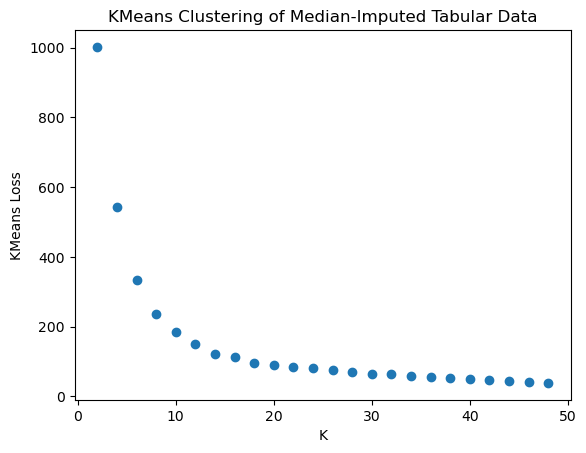

In [374]:
from scipy.sparse import hstack

#######
# cluster on tabular AND text
X_both = hstack((X_table, X_text))

# use kmeans
losses = {}

for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_both)
    labels_both = km.predict(X_both)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the tabular clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_both)
labels_both = km.predict(X_both)

cluster_ciks = defaultdict(list)
for row, label in enumerate(labels_both):
    cluster_ciks[label].append(df_joined["cik"][row])

print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    print("Label", label)
    print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])


In [ ]:
# TODO
# X_table bad clustering
#   Kill skewed outlier cols in X_table?
#   Try diff clust algs (also for X_text maybe)
#   diff normalization (sigmoid, etc)

# Visualization
#   reduce to 2dim, plot on 2d scatter, then label "selected companies" to be highly rigorous and scientific ;)